In [1]:
import pandas as pd
import glob
import numpy as np

from urllib.request import urlretrieve
import os

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import ast
import matplotlib.pyplot as plt

In [1]:
with open('./s2orc_full_text_nlp_ml.txt') as f:
    lines = f.read().splitlines()

In [2]:
# from urllib.request import urlretrieve
# import gzip, shutil

# for fname in lines:
#     if not fname.startswith('https:/'):
#         fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]
        
#     path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

#     with gzip.open(path, 'r') as f_in, open('.'.join(path.split('.')[:-1]).replace('raw-data', 'processed-data'), 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [3]:
path = "raw-data"
does_exist = os.path.exists(path)
if not does_exist:
    os.makedirs(path)

    for fname in lines:
        if not fname.startswith('https:/'):
            fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]

        path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

        pd.read_parquet(path)
        print(path)

In [5]:
def process_text(text):
    wnpos = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'
    wnl = WordNetLemmatizer()

    tokens = word_tokenize(text)
    tokens_pos = pos_tag(tokens)
    lemmas = []
    for t, pos in tokens_pos:
        new_pos = wnpos(pos)
        lemmas.append(wnl.lemmatize(t, pos=new_pos))
    return lemmas

In [6]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

search_terms = ['democra']
exclude_term = 'democrats'

matches = list()
num_nonreadable = 0

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        for target in [row['metadata']['title'], row['metadata']['abstract'], row['content']['grobid']['contents']]:
            if target:
                target_sents = nltk.tokenize.sent_tokenize(target)
            else:
                num_nonreadable += 1
                continue
            
            for s in search_terms:
                matches.extend([(row['id'], m) for m in target_sents if s in m.lower() and exclude_term not in m.lower()])

In [7]:
num_nonreadable

2082

In [8]:
matches_df = pd.DataFrame(matches, columns=['Corpus ID', 'Excerpt'])

In [9]:
matches_df.sample(frac=1).to_csv('excerpts.csv')

In [10]:
matches_df

,Corpus ID,Excerpt
0,258378195,Table 2 :\n2Some statisics for our new data se...
1,258378195,Populism versus democracy.
2,258378195,Populism ver- sus democracy.
3,258378195,"Werner Wirth, Martin Wettstein, Dominique Wirz..."
4,208909894,Pratham Books 4 is a non-profit organization w...
...,...,...
3406,233365240,On the democratic role of news recommenders.
3407,233365240,On the democratic role of news recommenders.
3408,226283642,"In rural Virginia, Sen. Warner ran 8 -10 point..."
3409,226283642,They go into a voting booth having no idea wha...


## Over Time

In [2]:
filtered_papers = set(pd.read_csv('excerpts.csv')['Corpus ID'])

In [3]:
all_years = []
filtered_rows = []

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        if row['id'] in filtered_papers:
            filtered_rows.append(row)
            
        if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
            all_years.append(row['metadata']['publication_date']['year'])

In [4]:
df = pd.DataFrame(filtered_rows)

In [5]:
filtered_years = []

for index, row in df.iterrows():
    if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
        filtered_years.append(row['metadata']['publication_date']['year'])

In [6]:
import numpy as np
import matplotlib.pyplot as plt

filtered_uniq, filtered_counts = np.unique(filtered_years, return_counts=True)

In [7]:
denom = (filtered_uniq.reshape(-1, 1) == np.array(all_years).reshape(1, -1)).sum(axis=1)

In [8]:
filtered_uniq

array([1969., 1974., 1975., 1976., 1977., 1978., 1979., 1980., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023.])

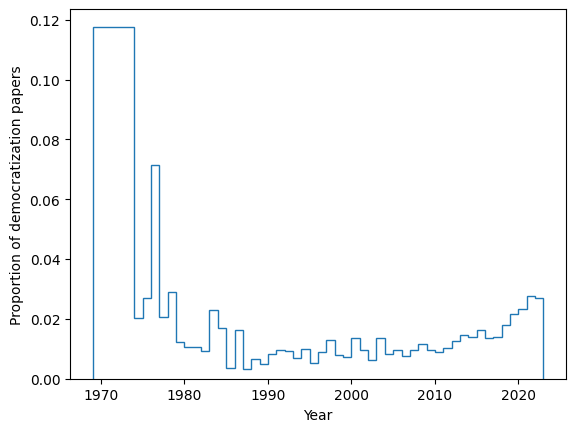

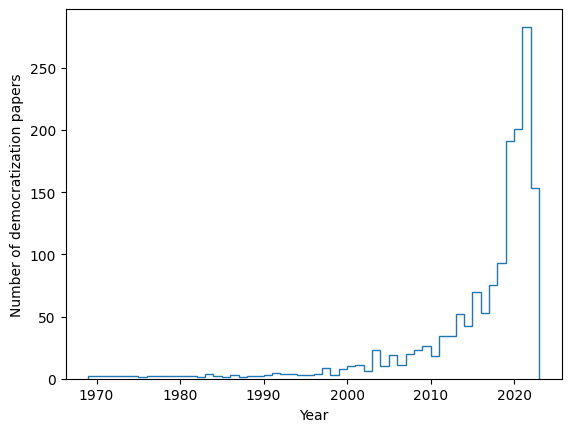

In [28]:
plt.stairs((filtered_counts / denom)[filtered_uniq > 1970], filtered_uniq[filtered_uniq >= 1969])
plt.xlabel("Year")
plt.ylabel("Proportion of democratization papers")
plt.show()

plt.stairs(filtered_counts[filtered_uniq > 1970], filtered_uniq[filtered_uniq >= 1969])
plt.xlabel("Year")
plt.ylabel("Number of democratization papers")
plt.show()

## Affiliations

In [10]:
# from s2aff import S2AFF
# from s2aff.ror import RORIndex
# from s2aff.model import NERPredictor, PairwiseRORLightGBMReranker

In [11]:
# # an example affiliation
# raw_affiliation = "Microsoft Research\nBangaloreIndia"

# # instantiate the ner model and the ror index. loading first time will take ~10-30s
# ner_predictor = NERPredictor(use_cuda=False)  # defaults to models in the data directory
# ror_index = RORIndex()  # ditto

In [12]:
# candidates, scores = ror_index.get_candidates_from_raw_affiliation("Argentina", ner_predictor)
# ror_index.ror_dict[candidates[0]]

In [13]:
exclude_terms = set([
    'germany',
    'department of linguistics',
    'uk',
    'school of computer science',
    'china',
    'usa',
    'computer science',
    'india',
    'italy',
    'berkeley',
    'united kingdom',
    'computer science department',
    'department of computer science and engineering',
    'department of computer science',
    'beijingchina',
])

In [14]:
all_affils = []

for index, row in df.iterrows():
    if row['content']['grobid']['annotations']['author_affiliation']:
        affiliation_pos = ast.literal_eval(row['content']['grobid']['annotations']['author_affiliation'])
        
        paper_affils = []
        for pos in affiliation_pos:
            start, end = pos['start'], pos['end']
            if type(start) != int:
                start = int(start)
            if type(end) != int:
                end = int(end)

            raw_affils = row['content']['grobid']['contents'][start:end].strip().lower().split('\n')
            paper_affils.extend(raw_affils)
            
        all_affils.extend(list(set([affil for affil in paper_affils if affil not in exclude_terms])))

In [15]:
# uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)
# uniq_affils = uniq_affils[np.argsort(-counts_affils)]
# counts_affils = counts_affils[np.argsort(-counts_affils)]

In [16]:
# affils_map = {}

# for raw_affil in uniq_affils[:200]:
#     candidates, scores = ror_index.get_candidates_from_raw_affiliation(raw_affil, ner_predictor)
#     cand_info = ror_index.ror_dict[candidates[0]]
#     if "Education" in cand_info["types"] or "Company" in cand_info["types"] or "Nonprofit" in cand_info["types"]:
#         affils_map[raw_affil] = cand_info["name"]

In [17]:
# relabeled_affils = [affils_map[affil] for affil in all_affils if affil in affils_map]
# uniq_affils, counts_affils = np.unique(relabeled_affils, return_counts=True)

uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)

k = 20
topk_affils = np.argsort(-counts_affils)[:k]
list(zip(uniq_affils[topk_affils], counts_affils[topk_affils]))

[('stanford university', 37),
 ('carnegie mellon university', 36),
 ('columbia university', 33),
 ('university of california', 31),
 ('cnrs', 26),
 ('university of edinburgh', 26),
 ('university of cambridge', 25),
 ('university of stuttgart', 22),
 ('university of copenhagen', 19),
 ('university of washington', 19),
 ('university of maryland', 17),
 ('university of michigan', 17),
 ('university of pennsylvania', 16),
 ('microsoft research', 16),
 ('university of amsterdam', 15),
 ('ibm research', 15),
 ('purdue university', 14),
 ('university of toronto', 13),
 ('johns hopkins university', 13),
 ('charles university', 13)]

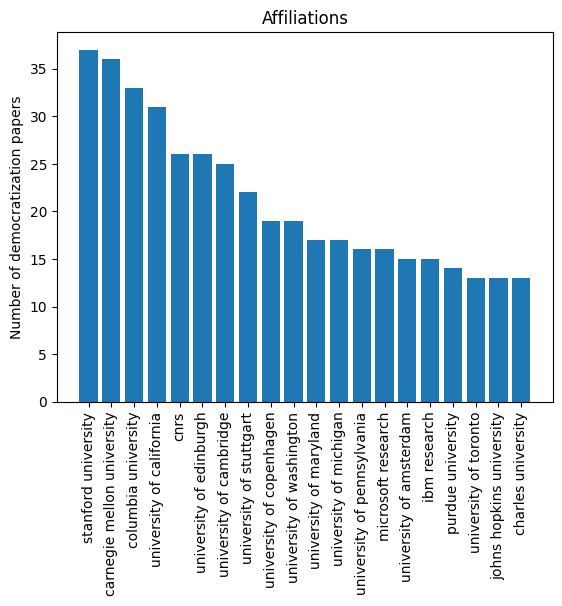

In [18]:
plt.bar(uniq_affils[topk_affils], counts_affils[topk_affils])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Affiliations')
plt.show()

## Authors

In [19]:
all_authors = []

for index, row in df.iterrows():
    if row['metadata']['authors']:
        authors = ast.literal_eval(row['metadata']['authors'])
        
        for author in authors:
            all_authors.append(' '.join([author['first'].strip().lower()] + [t.strip().lower() for t in author['middle']] + [author['last'].strip().lower()]))

In [20]:
uniq_authors, counts_authors = np.unique(all_authors, return_counts=True)

In [21]:
k = 20
topk_authors = np.argsort(-counts_authors)[:k]
list(zip(uniq_authors[topk_authors], counts_authors[topk_authors]))

[('dan goldwasser', 17),
 ('preslav nakov', 16),
 ('noah a. smith', 13),
 ('ekaterina shutova', 12),
 ('gabriella lapesa', 10),
 ('heng ji', 8),
 ('sebastian padó', 8),
 ('kathleen mckeown', 8),
 ('noam slonim', 8),
 ('kyo kageura', 7),
 ('mark dredze', 7),
 ('douwe kiela', 7),
 ('yulia tsvetkov', 7),
 ('josef ruppenhofer', 7),
 ('percy liang', 7),
 ('henning wachsmuth', 7),
 ('lu wang', 6),
 ('trevor cohn', 6),
 ('iryna gurevych', 6),
 ('yulan he', 6)]

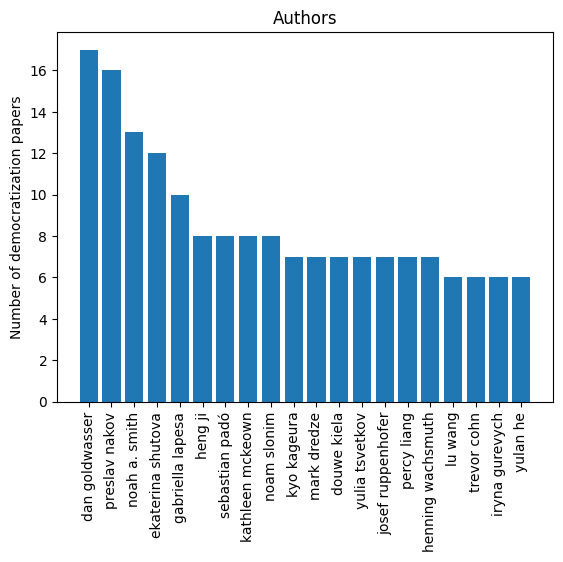

In [22]:
plt.bar(uniq_authors[topk_authors], counts_authors[topk_authors])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization papers')
plt.title('Authors')
plt.show()

## Paper structure

In [23]:
excerpts_df = pd.read_csv('excerpts.csv')
excerpts_map = {}

for index, row in excerpts_df.iterrows():
    if row['Corpus ID'] not in excerpts_map:
        excerpts_map[row['Corpus ID']] = []
    excerpts_map[row['Corpus ID']].append(row['Excerpt'])

In [24]:
all_sections = []

for index, row in df.iterrows():
    for excerpt in excerpts_map[row['id']]:
        excerpt_idx = row['metadata']['title'].find(excerpt)
        if excerpt_idx != -1:
            all_sections.append("Title")
            continue

        if row['metadata']['abstract']:
            excerpt_idx = row['metadata']['abstract'].find(excerpt)
            if excerpt_idx != -1:
                all_sections.append("Abstract")
                continue
        
        excerpt_idx = row['content']['grobid']['contents'].find(excerpt)

        if row['content']['grobid']['annotations']['section_header']:
            section_headers = ast.literal_eval(row['content']['grobid']['annotations']['section_header'])

            prev_header = "Abstract"
            for header in section_headers:
                start, end = header['start'], header['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)

                if excerpt_idx < start:
                    all_sections.append(prev_header)
                    break

                prev_header = row['content']['grobid']['contents'][start:end]

In [25]:
uniq_sections, counts_sections = np.unique(all_sections, return_counts=True)

In [26]:
topk_sections = np.argsort(-counts_sections)[:k]
list(zip(uniq_sections[topk_sections], counts_sections[topk_sections]))

[('Introduction', 365),
 ('Abstract', 216),
 ('Conclusion', 57),
 ('Table 4 :', 34),
 ('Related Work', 24),
 ('Table 1 :', 21),
 ('Figure 3 :', 20),
 ('Table 5 :', 19),
 ('Table 3 :', 19),
 ('Conclusions', 19),
 ('Evaluation', 19),
 ('Table 7 :', 18),
 ('Table 6 :', 17),
 ('::', 17),
 ('Table 2 :', 16),
 ('Figure 1 :', 15),
 ('Discussion', 15),
 ('Broader Impact', 14),
 ('Figure 2 :', 14),
 ('Results', 13)]

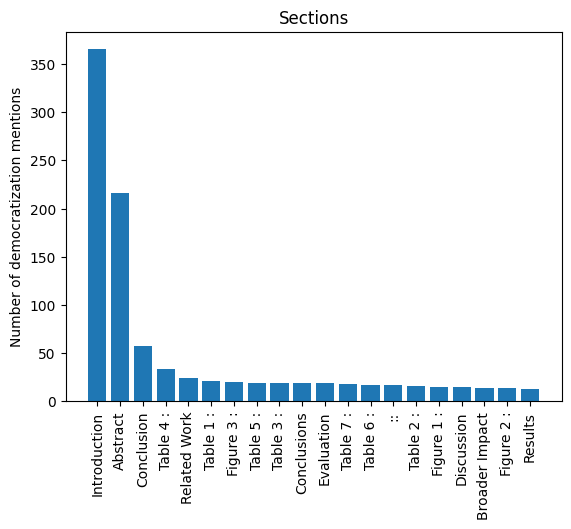

In [27]:
plt.bar(uniq_sections[topk_sections], counts_sections[topk_sections])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization mentions')
plt.title('Sections')
plt.show()